In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.lines as mlines
import plotly.express as px

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8772\684091709.py:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
data = pd.read_excel("TF_BIRTHS.xlsx", parse_dates=True)
data.rename(columns={"DT_DATE": "date", "MS_NUM_BIRTHS": "nb_birth"}, inplace=True)
print(data)
data.info()
data.describe()
# une moyenne de 123 800 naissances par an (sur les 29 ans enregistrées) -> cohérent

c:\Users\Utilisateur\anaconda3\envs\libDataScience\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


            date  nb_birth
0     1992-01-01       219
1     1992-01-02       331
2     1992-01-03       420
3     1992-01-04       282
4     1992-01-05       252
...          ...       ...
10953 2021-12-27       341
10954 2021-12-28       377
10955 2021-12-29       338
10956 2021-12-30       325
10957 2021-12-31       229

[10958 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10958 entries, 0 to 10957
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      10958 non-null  datetime64[ns]
 1   nb_birth  10958 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 171.3 KB


,nb_birth
count,10958.000000
mean,327.624019
std,80.125454
min,148.000000
25%,237.000000
50%,358.000000
75%,389.000000
max,493.000000


            date  nb_birth
9862  2019-01-01       206
9863  2019-01-02       327
9864  2019-01-03       338
9865  2019-01-04       358
9866  2019-01-05       215
...          ...       ...
10222 2019-12-27       392
10223 2019-12-28       204
10224 2019-12-29       207
10225 2019-12-30       310
10226 2019-12-31       302

[365 rows x 2 columns]


<AxesSubplot: title={'center': 'First plot of raw data for year 2019'}, xlabel='date', ylabel='nb_birth'>

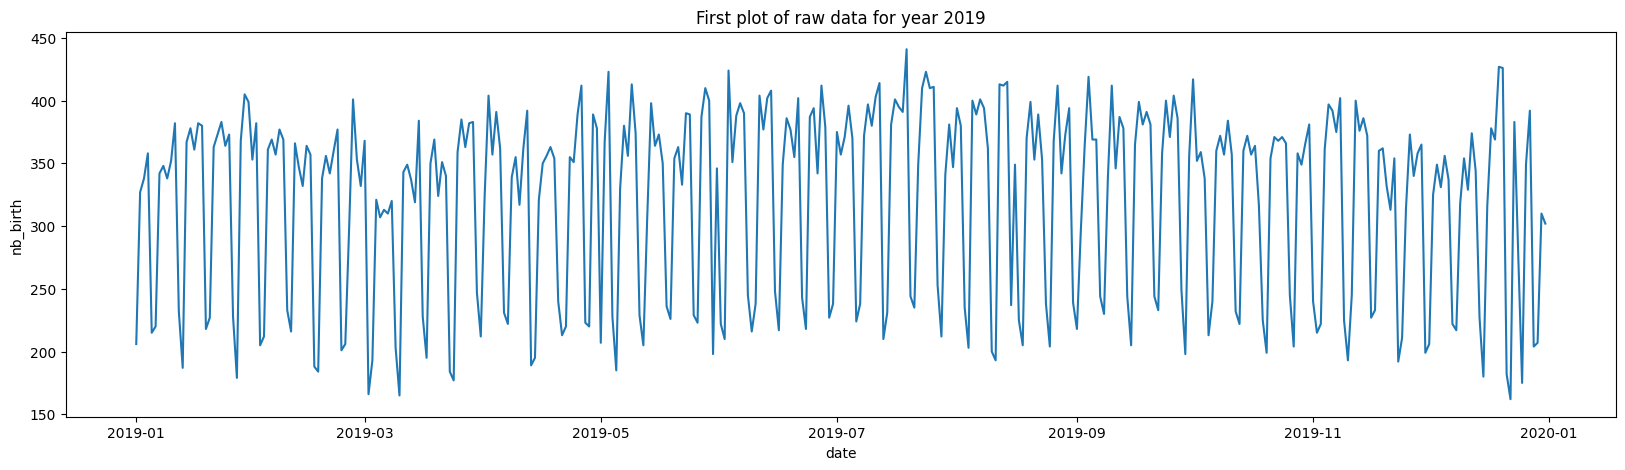

In [5]:
# simple plot of 2019 data
# print raw and smoothed data for 2019
annee = 2019
sub_data = data[data['date'].dt.year == annee].copy()
print(sub_data)

plt.figure(figsize=(20, 5))
plt.title("First plot of raw data for year 2019")
sns.lineplot(data=sub_data, x="date", y="nb_birth")


In [6]:
# get the sundays of 2019 
df_sundays = pd.DataFrame({"date":pd.date_range("2019-01-01", "2019-12-31")})
df_sundays['is_sunday'] = df_sundays['date'].dt.day_of_week==6
df_sundays['value'] = df_sundays.is_sunday.map({True:1000, False:0})
print(df_sundays)

# get public holidays of 2019
public_holidays = pd.DataFrame({"date": ["2019-01-01", "2019-04-22", "2019-05-01", "2019-05-30", "2019-06-10", "2019-07-21", "2019-08-15", "2019-11-01", "2019-11-11", "2019-12-25"]})
public_holidays['date'] = pd.to_datetime(public_holidays['date'])

          date  is_sunday  value
0   2019-01-01      False      0
1   2019-01-02      False      0
2   2019-01-03      False      0
3   2019-01-04      False      0
4   2019-01-05      False      0
..         ...        ...    ...
360 2019-12-27      False      0
361 2019-12-28      False      0
362 2019-12-29       True   1000
363 2019-12-30      False      0
364 2019-12-31      False      0

[365 rows x 3 columns]


Text(0.5, 1.0, 'Fig 1 : Impact of week-ends and public holidays on birth count')

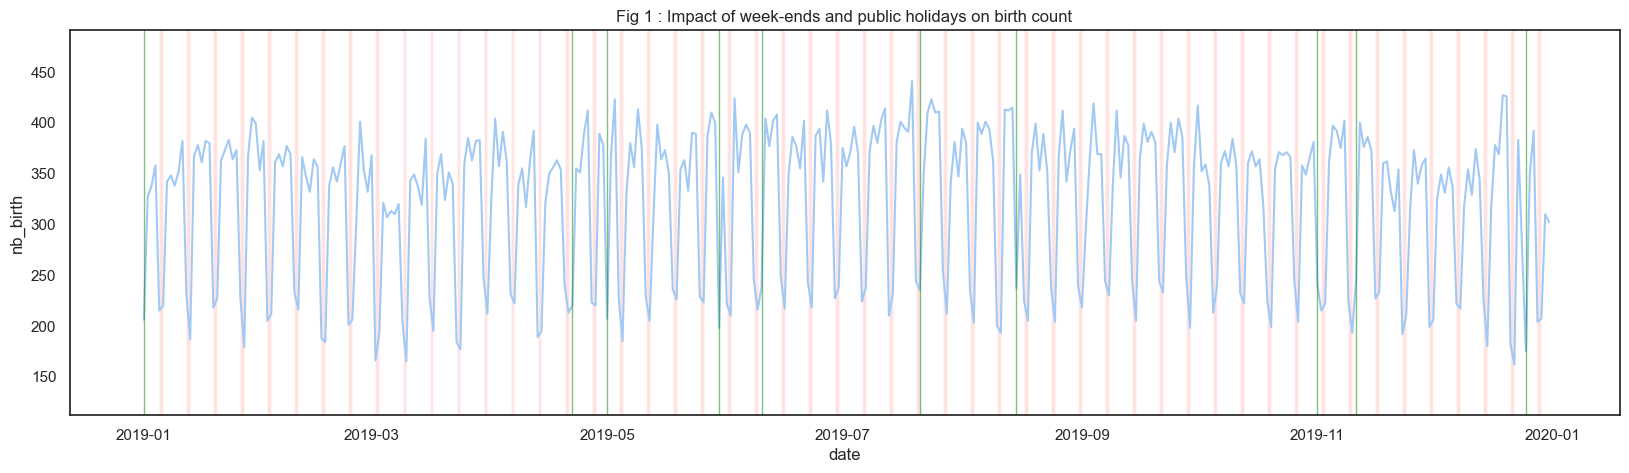

In [7]:
# Validate that drops correspond to week-ends or public holidays

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")

# plot vertical line for public holidays
for i in range(len(public_holidays)):
    line = public_holidays.iloc[i]
    date = line["date"]
    plt.axvline(date, color="green", linewidth=1, alpha=0.5)

# plot color bar for sundays (variante with barplot)
plt.bar(
    x=df_sundays["date"],
    height=df_sundays["value"],
    color="r",
    alpha=0.3,
    width=-1,
    align="edge",
)
plt.ylim(min(sub_data["nb_birth"]) - 50, max(sub_data["nb_birth"]) + 50)
plt.title("Fig 1 : Impact of week-ends and public holidays on birth count")

<AxesSubplot: xlabel='date', ylabel='nb_birth'>

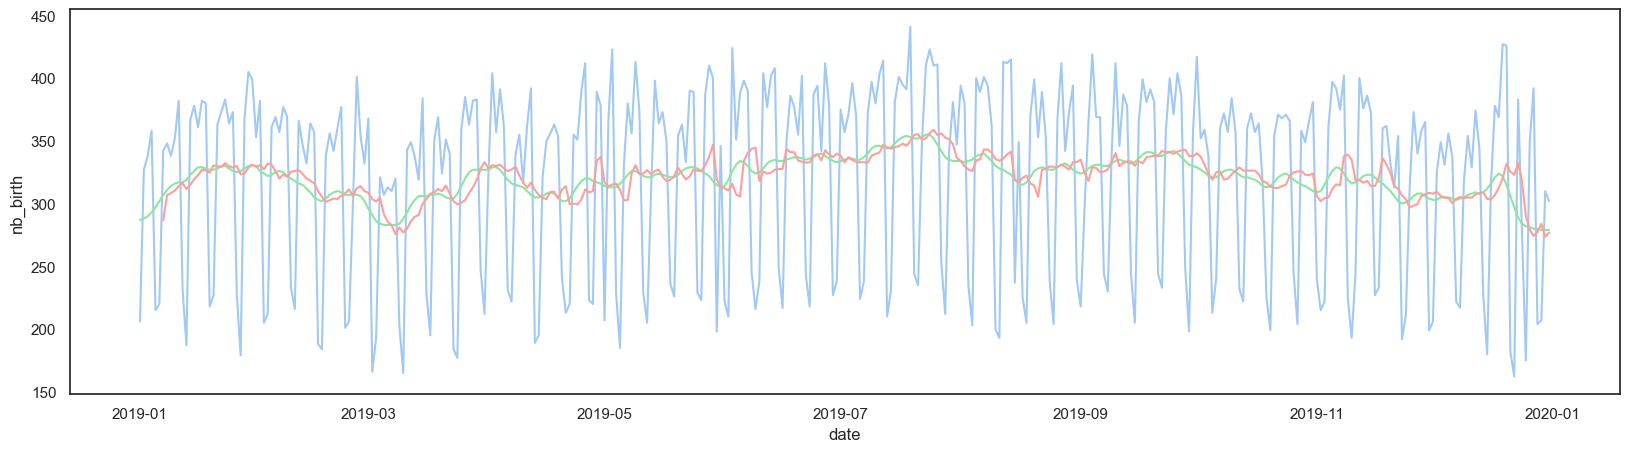

In [23]:
# compute smoothing using gaussian filter 1d de Scipy
sigma = 3
sub_data['smooth_gaussian'] = gaussian_filter1d(np.array(sub_data["nb_birth"]), sigma=sigma).round(1)
sub_data["smooth_rolling_mean"] = sub_data.nb_birth.rolling(7).mean().round(1)

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_gaussian", color="g")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

# choose rolling mean because better reflect of reality : childbirth not given on week-end will be given on the rest of the week 
# -> make sense to average week wise, not only smoothen mathematically

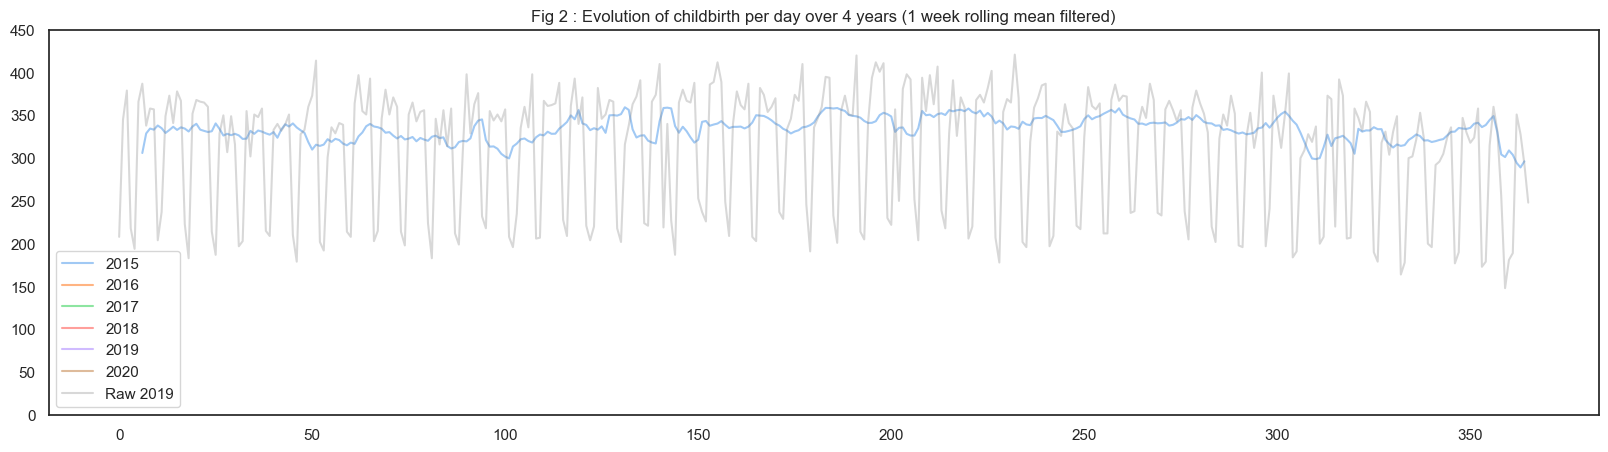

In [75]:
# superpose several years to see tendancy
# => using rolling mean make it bug :(
plt.figure(figsize=(20, 5))
sns.set_theme(style="white", palette="pastel")

# year loop
year_data = pd.DataFrame()

for year in range(2015, 2021):
    year_data_smoothed = pd.DataFrame()
    data_tmp = data.loc[
        data['date'].dt.year==year,
        :,
    ].copy()

    # compute smoothing using rolling mean of 7 days
    year_data_smoothed = data_tmp['nb_birth'].rolling(7).mean().round(1)

    year_data[str(year)] = year_data_smoothed.copy() # sauve Nan apres la premiere année
    plt.plot(range(365), year_data[str(year)], label=year)


# add 2019 on plot (without filter)
data_2019 = data.loc[data['date'].dt.year==year, :]
plt.plot(
    range(366), data_2019["nb_birth"], color="grey", alpha=0.3, label="Raw 2019"
)

plt.ylim((0, 450))
plt.legend()
plt.title("Fig 2 : Evolution of childbirth per day over 4 years (1 week rolling mean filtered)")
plt.show()

In [35]:
# certaines années sont bissextiles, donc avec un nb differents de jours. 
# on change de preprocessing pour devenir independant du nombre de jours
# -> on passe les jours en colonne + utilisation de plotly

ROLLING_PERIOD = 7

df_per_year = pd.DataFrame(
    {"date": pd.date_range("2019-01-01", "2019-12-31").strftime("%d/%m")})

for year in data.date.dt.year.unique():
    tmp = data[data.date.dt.year == year].copy()
    tmp["date"] = tmp["date"].dt.strftime("%d/%m")
    # on utilise la date en index (pour se simplifier la vie)
    tmp = (
        tmp.set_index("date")
    )
    # on applique la moyenne glissante
    tmp = (
        tmp.rolling(ROLLING_PERIOD)
        .mean()
    )
    # on arrondie et reset l'index
    tmp = (
        tmp.nb_birth.round(1)
        .rename(year)
        .reset_index()
    )
    # on stock dans df_per_year date par date
    df_per_year = df_per_year.merge(tmp, on="date")

print(df_per_year)

      date   1992   1993   1994   1995   1996   1997   1998   1999   2000  \
0    01/01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    02/01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    03/01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    04/01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    05/01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
360  27/12  282.1  293.3  291.7  279.6  282.1  279.1  272.3  300.1  271.4   
361  28/12  283.9  294.3  286.6  279.9  286.7  283.7  268.6  296.6  269.4   
362  29/12  283.4  295.9  288.7  283.4  290.6  286.3  266.9  289.4  270.7   
363  30/12  284.4  293.1  289.9  286.1  297.7  279.7  271.6  281.7  274.3   
364  31/12  288.0  292.3  286.3  286.6  293.1  278.9  272.3  274.3  274.1   

     ...   2012   2013   2014   2015   2016   2017   2018   2019   2020   2

Text(0.5, 1.0, 'Plot of the cycles of the moon on 2019')

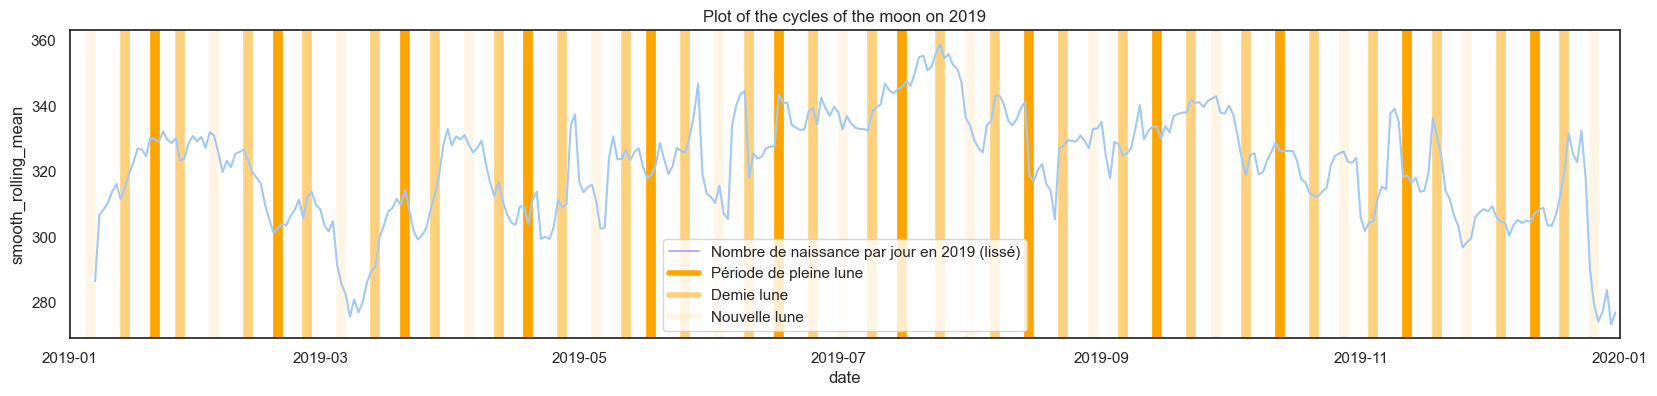

In [58]:
# moon calendar 2019
moon_2019 = pd.read_csv('moon2019.txt')

moon_2019["Date"] = pd.to_datetime(moon_2019["Date"])
moon_2019.head()

plt.figure(figsize=(20, 4))

for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["Date"]
    type = line["Moon"]
    if type == 1:
        plt.axvline(date, color="orange", linewidth=7, alpha=1)
    elif type == 0.5:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.5)
    elif type == 0:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.1)

sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="b")

plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour en 2019 (lissé)",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=1,
            linewidth=4,
            markersize=15,
            label="Période de pleine lune",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.5,
            linewidth=4,
            markersize=15,
            label="Demie lune"
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.1,
            linewidth=4,
            markersize=15,
            label="Nouvelle lune",
        ),
    ]
)

plt.title("Plot of the cycles of the moon on 2019")


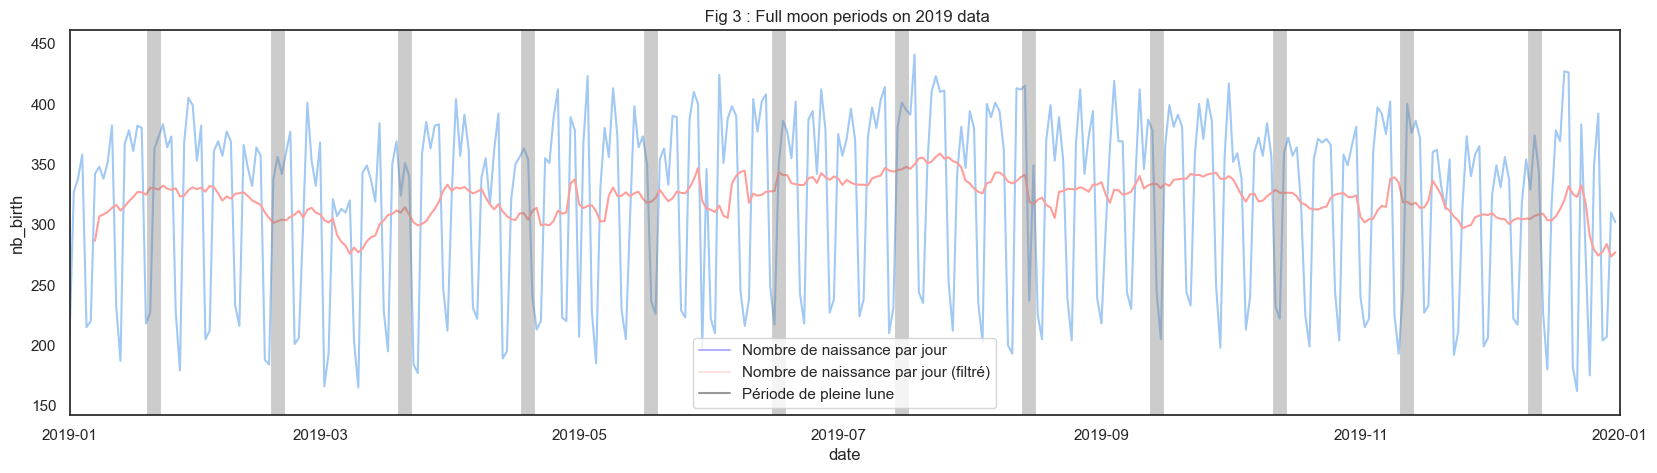

In [56]:
# final plot : 2019 filtered and unfiltered, sundays, full moons
import matplotlib.lines as mlines

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

# plot periods of full moon
for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["Date"]
    type = line["Moon"]
    if type == 1:
        plt.axvline(date, color="grey", linewidth=10, alpha=0.4)


plt.ylim(min(sub_data["nb_birth"]) - 20, max(sub_data["nb_birth"]) + 20)
plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.title(
    " Fig 3 : Full moon periods on 2019 data"
)

# plot legend
plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour",
        ),
        mlines.Line2D(
            [],
            [],
            color="r",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour (filtré)",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            alpha=0.4,
            markersize=15,
            label="Période de pleine lune",
        ),
    ]
)